In [22]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

tf.compat.v1.enable_v2_behavior()

np.random.seed(0)

tff.federated_computation(lambda: 'Hello, World!')()

b'Hello, World!'

In [2]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

/opt/conda/lib/python3.6/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:63: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


In [19]:
emnist_train.client_ids[:10]

['f0000_14',
 'f0001_41',
 'f0005_26',
 'f0006_12',
 'f0008_45',
 'f0011_13',
 'f0014_19',
 'f0016_39',
 'f0017_07',
 'f0022_10']

In [3]:
emnist_train.element_type_structure

OrderedDict([('label', TensorSpec(shape=(), dtype=tf.int32, name=None)),
             ('pixels',
              TensorSpec(shape=(28, 28), dtype=tf.float32, name=None))])

In [4]:
example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])

example_element = next(iter(example_dataset))

example_element['label'].numpy()

5

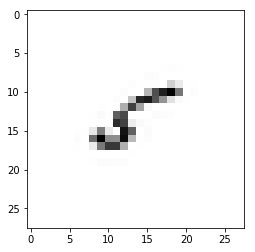

In [6]:
from matplotlib import pyplot as plt
plt.imshow(example_element['pixels'].numpy(), cmap='gray', aspect='equal')
plt.grid(False)
plt.show()

In [29]:
NUM_CLIENTS = 20
NUM_EPOCHS = 5
BATCH_SIZE = 64
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER=10

def preprocess(dataset):

  def batch_format_fn(element):
    """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
    return collections.OrderedDict(
        x=tf.reshape(element['pixels'], [-1, 784]),
        y=tf.reshape(element['label'], [-1, 1]))

  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

In [30]:
preprocessed_example_dataset = preprocess(example_dataset)

sample_batch = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(preprocessed_example_dataset)))

sample_batch

OrderedDict([('x', array([[1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     ...,
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)),
             ('y', array([[9],
                     [2],
                     [1],
                     [5],
                     [8],
                     [2],
                     [8],
                     [9],
                     [6],
                     [7],
                     [4],
                     [3],
                     [1],
                     [9],
                     [5],
                     [2],
                     [1],
                     [2],
                     [6],
                     [9],
                     [1],
                     [3],
                     [1],
                     [2],
          

In [31]:
def make_federated_data(client_data, client_ids):
  return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
  ]

In [34]:
type(emnist_train)

tensorflow_federated.python.simulation.hdf5_client_data.HDF5ClientData

In [32]:
sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]

federated_train_data = make_federated_data(emnist_train, sample_clients)

print('Number of client datasets: {l}'.format(l=len(federated_train_data)))
print('First dataset: {d}'.format(d=federated_train_data[0]))
print('Second dataset: {d}'.format(d=federated_train_data[1]))

Number of client datasets: 20
First dataset: <PrefetchDataset shapes: OrderedDict([(x, (None, 784)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>
OrderedDict([('x', <tf.Tensor: shape=(64, 784), dtype=float32, numpy=
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)>), ('y', <tf.Tensor: shape=(64, 1), dtype=int32, numpy=
array([[0],
       [8],
       [2],
       [7],
       [0],
       [8],
       [8],
       [3],
       [0],
       [9],
       [3],
       [2],
       [7],
       [1],
       [5],
       [2],
       [0],
       [5],
       [1],
       [5],
       [4],
       [0],
       [3],
       [3],
       [6],
       [7],
       [7],
       [0],
       [9],
       [9],
       [6],
       [2],
       [2],
       [8],
       [0],
       [1],
       [9],
 

In [11]:
f0000_14def create_keras_model():
  return tf.keras.models.Sequential([
      tf.keras.layers.Input(shape=(784,)),
      tf.keras.layers.Dense(10, kernel_initializer='zeros'),
      tf.keras.layers.Softmax(),
  ])

In [12]:
def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
  keras_model = create_keras_model()
  return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_example_dataset.element_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


In [13]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [14]:
str(iterative_process.initialize.type_signature)

'( -> <model=<trainable=<float32[784,10],float32[10]>,non_trainable=<>>,optimizer_state=<int64>,delta_aggregate_state=<>,model_broadcast_state=<>>@SERVER)'

In [15]:
state = iterative_process.initialize()

In [16]:
state, metrics = iterative_process.next(state, federated_train_data)
print('round  1, metrics={}'.format(metrics))

round  1, metrics=<sparse_categorical_accuracy=0.12839506566524506,loss=2.9675543308258057>


In [17]:
NUM_ROUNDS = 11
for round_num in range(2, NUM_ROUNDS):
  state, metrics = iterative_process.next(state, federated_train_data)
  print('round {:2d}, metrics={}'.format(round_num, metrics))

round  2, metrics=<sparse_categorical_accuracy=0.1415637880563736,loss=2.8178536891937256>
round  3, metrics=<sparse_categorical_accuracy=0.16769547760486603,loss=2.8049938678741455>
round  4, metrics=<sparse_categorical_accuracy=0.17139917612075806,loss=2.6759519577026367>
round  5, metrics=<sparse_categorical_accuracy=0.19279836118221283,loss=2.642240047454834>
round  6, metrics=<sparse_categorical_accuracy=0.19382716715335846,loss=2.4981446266174316>
round  7, metrics=<sparse_categorical_accuracy=0.24444444477558136,loss=2.360257148742676>
round  8, metrics=<sparse_categorical_accuracy=0.26358023285865784,loss=2.2955877780914307>
round  9, metrics=<sparse_categorical_accuracy=0.29135802388191223,loss=2.176128387451172>
round 10, metrics=<sparse_categorical_accuracy=0.3002057671546936,loss=2.1810338497161865>
